Merge peaks generated by scE2G pipeline for 22 cell types, and make enhancer-gene pairs (dist < 1M)

In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(genomation)
library(GenomicRanges)
library(Matrix)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDupl

Specify file path

In [2]:
dir.scE2G_res = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/software/scE2G_pipeline/240508/sc-E2G/test/results_BMMC/"
path.obj.seurat = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/2.seurat_pipeline.240506/obj.seurat.rds"
dir.output = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/"

In [3]:
dir.create(dir.output,recursive = T)

Warning message in dir.create(dir.output, recursive = T):
“'/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523' already exists”


Import seurat object

In [4]:
obj.seurat = readRDS(path.obj.seurat)

Import E-G pairs for each cluster

In [5]:
list.pairs.E2G = list()
for (cell_type.tmp in unique(obj.seurat$cell_type.rename)){
    list.pairs.E2G[[cell_type.tmp]] = readGeneric(paste(dir.scE2G_res,cell_type.tmp,"Kendall","Pairs.tsv.gz",sep = "/"),
                                                  header = T,
                                                  keep.all.metadata = T)


}

In [6]:
list.ABC.1M = list()
for (cell_type.tmp in unique(obj.seurat$cell_type.rename)){
    bed.tmp = readGeneric(paste(dir.scE2G_res,cell_type.tmp,"Predictions","EnhancerPredictionsAllPutative.tsv.gz",sep = "/"),
                                            header = T,
                                            keep.all.metadata = T)
    list.ABC.1M[[cell_type.tmp]] = bed.tmp[bed.tmp$distance < 10^6]
    rm(bed.tmp)
}

Check peak width

In [27]:
sort(table(obj.seurat$cell_type.rename))


ID2_hi_myeloid_prog         Plasma_cell                 ILC                cDC2 
                108                 379                 835                 859 
          MK_E_prog     CD8_pos_T_naive                 HSC                 pDC 
                884                1012                1072                1191 
           G_M_prog          Lymph_prog          Normoblast                B1_B 
               1203                1779                1780                1890 
      CD16_pos_Mono     Proerythroblast      Transitional_B     CD4_pos_T_naive 
               1894                2300                2810                4398 
       Erythroblast    Naive_CD20_pos_B CD4_pos_T_activated                  NK 
               4916                5052                5526                6929 
      CD14_pos_Mono           CD8_pos_T 
              10843               11589 

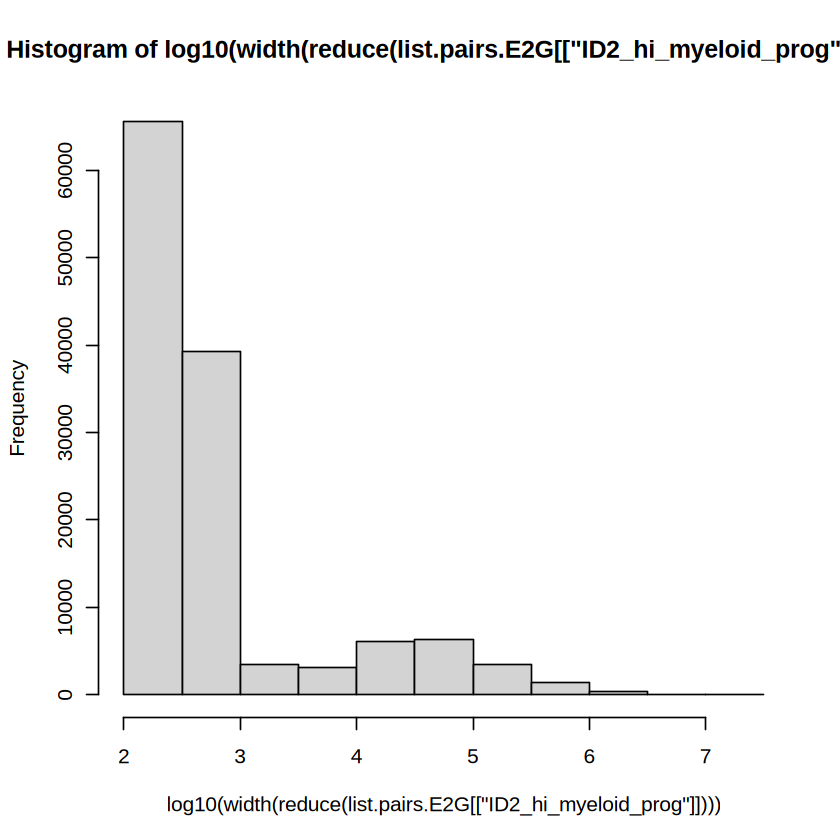

In [28]:
hist(log10(width(reduce(list.pairs.E2G[["ID2_hi_myeloid_prog"]]))))

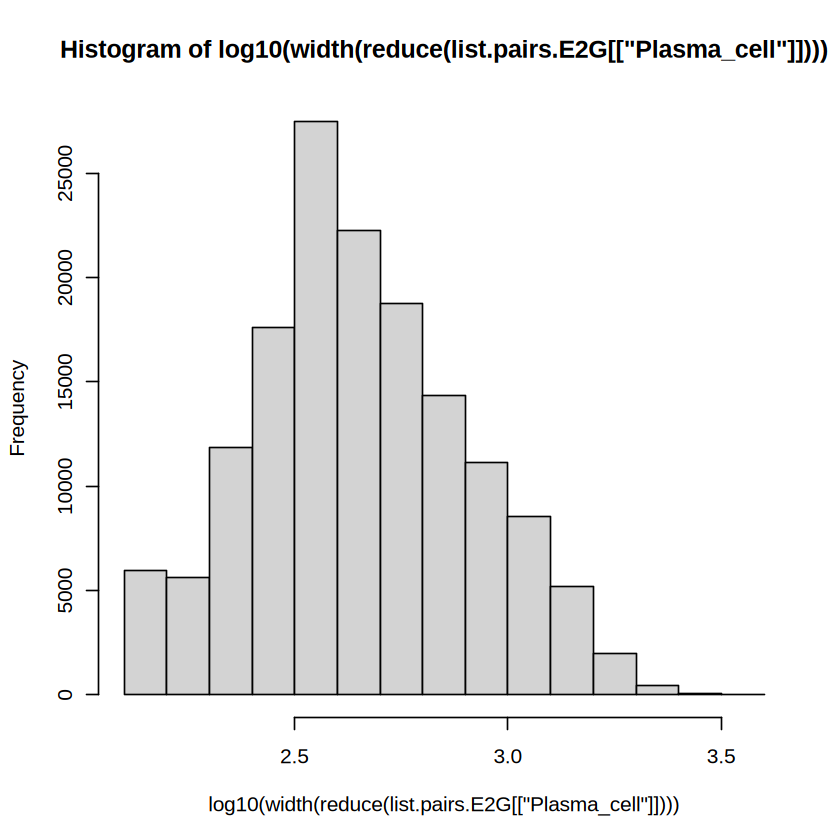

In [29]:
hist(log10(width(reduce(list.pairs.E2G[["Plasma_cell"]]))))

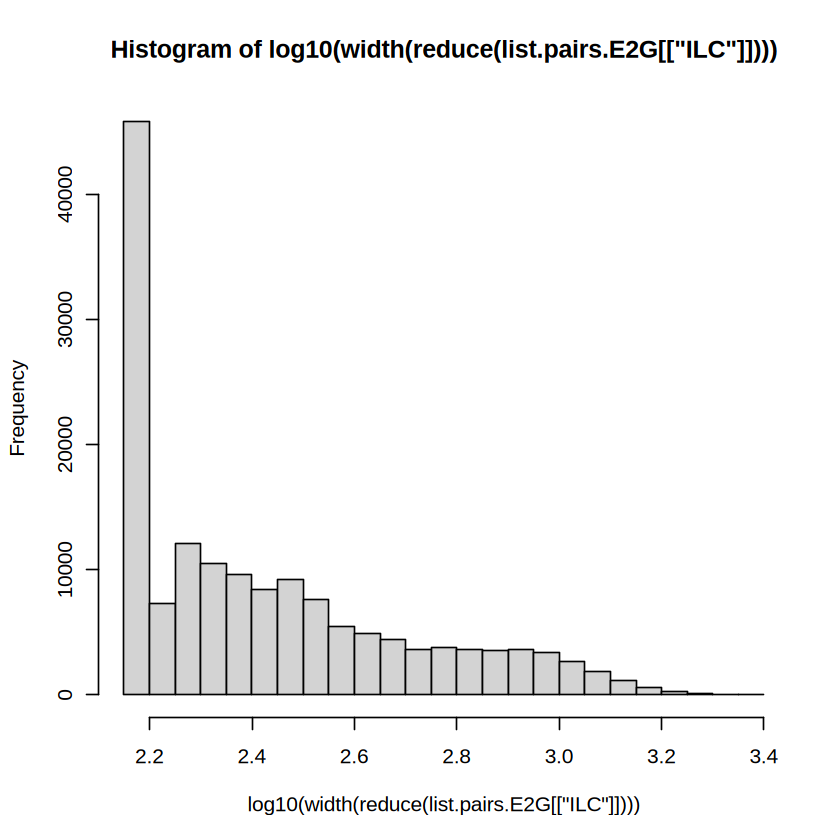

In [30]:
hist(log10(width(reduce(list.pairs.E2G[["ILC"]]))))

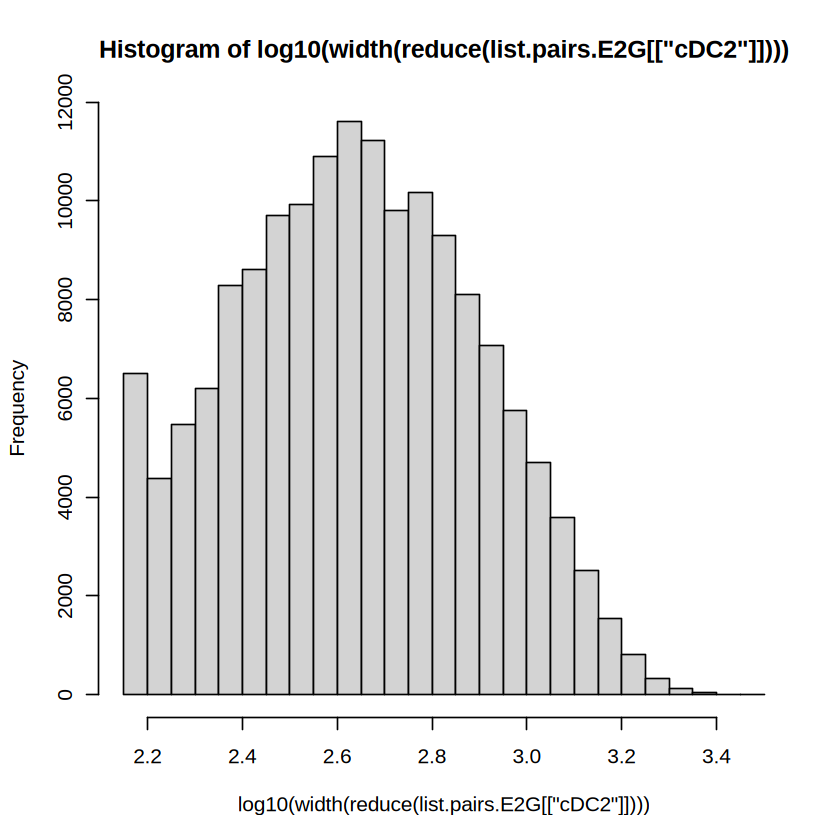

In [31]:
hist(log10(width(reduce(list.pairs.E2G[["cDC2"]]))))

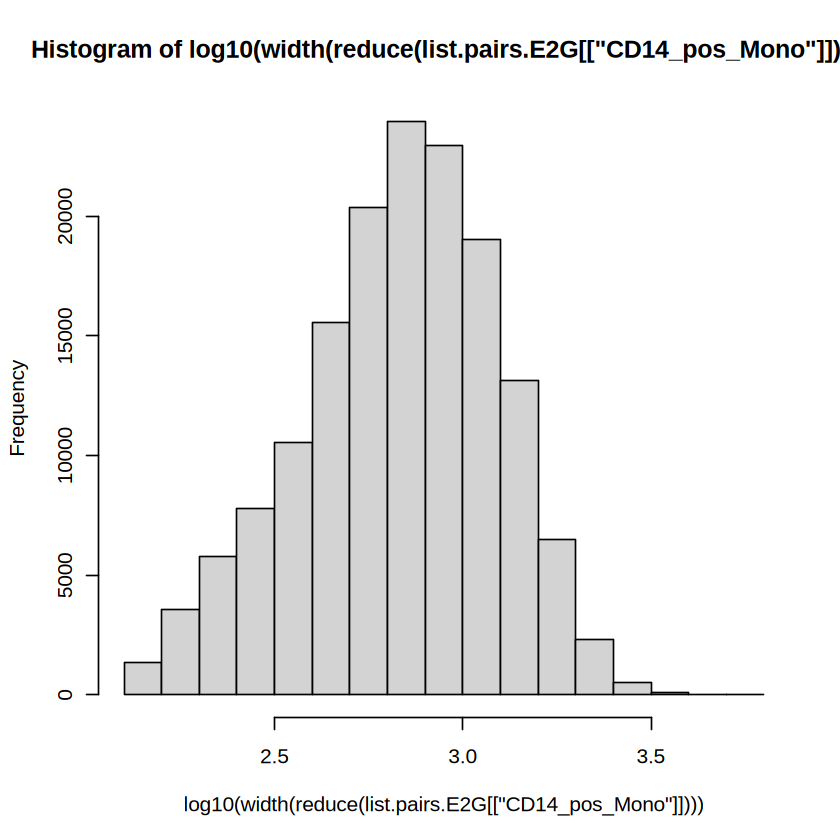

In [32]:
hist(log10(width(reduce(list.pairs.E2G[["CD14_pos_Mono"]]))))

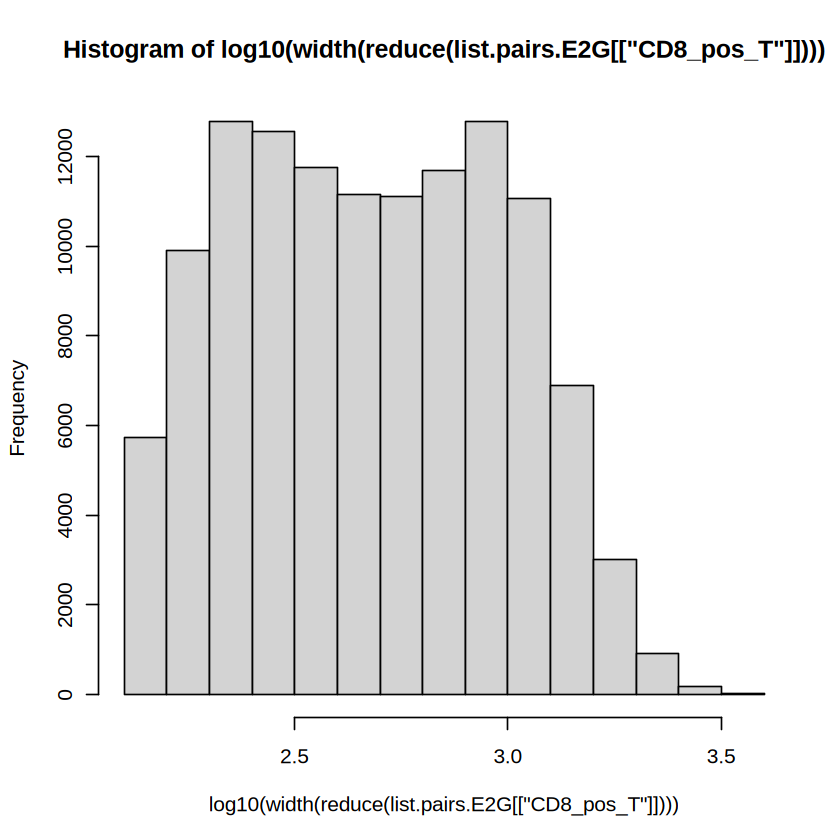

In [33]:
hist(log10(width(reduce(list.pairs.E2G[["CD8_pos_T"]]))))

Peak width of ID2_hi_myeloid_prog is wierd. It may due to low cell number.
Remove peaks of ID2_hi_myeloid_prog

In [35]:
list.pairs.E2G.filter = list.pairs.E2G
list.pairs.E2G.filter[["ID2_hi_myeloid_prog"]] = NULL

In [36]:
list.ABC.1M.filter = list.ABC.1M
list.ABC.1M.filter[["ID2_hi_myeloid_prog"]] = NULL

Merge peaks

In [40]:
bed.peaks = reduce(unlist(as(list.pairs.E2G.filter, "GRangesList")))
bed.peaks

GRanges object with 546854 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10010-10536      *
       [2]     chr1         96496-96699      *
       [3]     chr1       115495-115930      *
       [4]     chr1       180470-181899      *
       [5]     chr1       184379-184607      *
       ...      ...                 ...    ...
  [546850]     chrX 156008869-156009386      *
  [546851]     chrX 156019809-156020162      *
  [546852]     chrX 156025098-156025397      *
  [546853]     chrX 156029831-156030380      *
  [546854]     chrX 156030497-156030869      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

Make E-G pairs

In [41]:
pair.ABC.1M = unlist(as(list.ABC.1M.filter, "GRangesList"))

In [42]:
overlaps.res = findOverlaps(bed.peaks,
                            pair.ABC.1M)

In [43]:
pairs.peak_gene = bed.peaks[overlaps.res@from]
mcols(pairs.peak_gene)[,"TargetGene"] = mcols(pair.ABC.1M)[overlaps.res@to,"TargetGene"]
mcols(pairs.peak_gene)[,"PeakName"] = 
  paste(seqnames(pairs.peak_gene),
        start(pairs.peak_gene),
        end(pairs.peak_gene),
        sep = "-")

In [44]:
mcols(pairs.peak_gene)[,"PairName"] = 
  paste(mcols(pairs.peak_gene)[,"PeakName"],
        mcols(pairs.peak_gene)[,"TargetGene"],
        sep = "_")
pairs.peak_gene = pairs.peak_gene[order(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene = pairs.peak_gene[!duplicated(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene

GRanges object with 9830073 ranges and 3 metadata columns:
            seqnames              ranges strand |  TargetGene
               <Rle>           <IRanges>  <Rle> | <character>
        [1]     chr1 100004103-100004301      * |         AGL
        [2]     chr1 100004103-100004301      * |      CDC14A
        [3]     chr1 100004103-100004301      * |         DBT
        [4]     chr1 100004103-100004301      * |       EXTL2
        [5]     chr1 100004103-100004301      * |       FRRS1
        ...      ...                 ...    ... .         ...
  [9830069]     chrX   99980528-99980848      * |      PCDH19
  [9830070]     chrX   99980528-99980848      * |      TSPAN6
  [9830071]     chrX   99980528-99980848      * |        XKRX
  [9830072]     chrX     9999312-9999592      * |       TBL1X
  [9830073]     chrX     9999312-9999592      * |        WWC3
                          PeakName               PairName
                       <character>            <character>
        [1] chr1-10

Generate peak x cell matrix

In [45]:
bed.peaks.matrix = reduce(pairs.peak_gene)
bed.peaks.matrix

GRanges object with 540429 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10010-10536      *
       [2]     chr1         96496-96699      *
       [3]     chr1       115495-115930      *
       [4]     chr1       180470-181899      *
       [5]     chr1       184379-184607      *
       ...      ...                 ...    ...
  [540425]     chrX 156008869-156009386      *
  [540426]     chrX 156019809-156020162      *
  [540427]     chrX 156025098-156025397      *
  [540428]     chrX 156029831-156030380      *
  [540429]     chrX 156030497-156030869      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

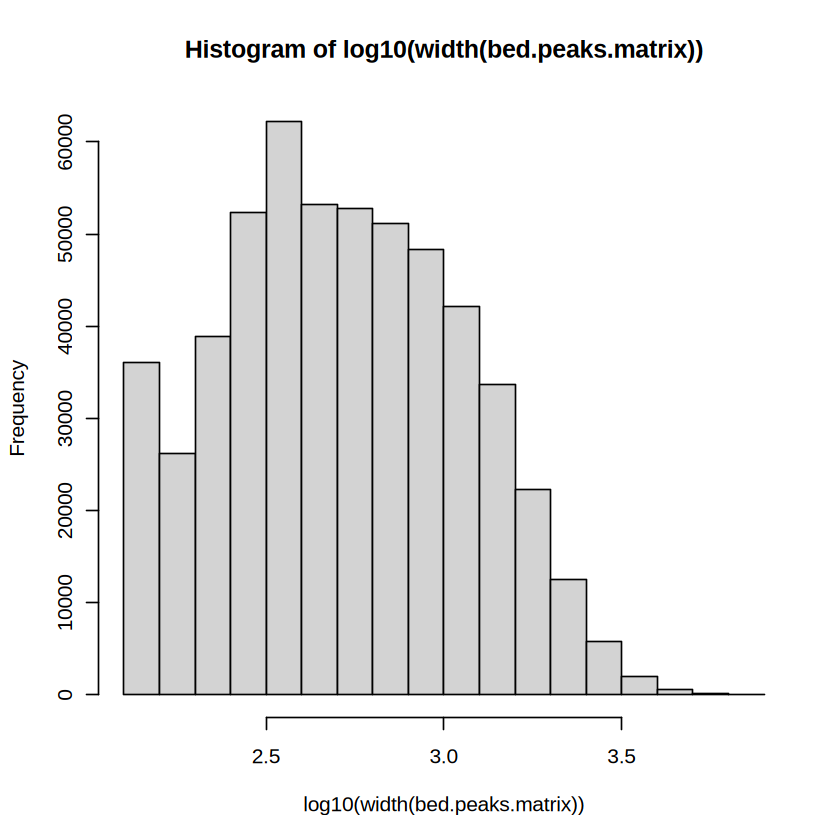

In [46]:
hist(log10(width(bed.peaks.matrix)))

Generate ATAC matrix

In [ ]:
future::plan("multicore", workers = 32)
atac.matrix <- FeatureMatrix(
  fragments = obj.seurat@assays$ATAC_empty@fragments,
  features = bed.peaks.matrix,
  cells = colnames(obj.seurat@assays$RNA$counts)
)
future::plan("sequential")

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [82]:
obj.seurat[["ATAC"]] <- CreateChromatinAssay(
  counts = atac.matrix,
  fragments = obj.seurat@assays$ATAC_empty@fragments
)
DefaultAssay(obj.seurat) <- "ATAC"

In [83]:
obj.seurat <- obj.seurat %>%
  RunTFIDF() %>%
  FindTopFeatures(min.cutoff = 'q0') %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

09:42:14 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

09:42:14 Read 69249 rows and found 29 numeric columns

09:42:14 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

09:42:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:42:20 Writing NN index file to temp file /tmp/RtmpDP02s5/file1e9f566ffc28e

09:42:20 Searching Annoy index using 1 thread, search_k = 3000

09:42:45 Annoy recall = 100%

09:44:32 Commencing smooth kNN distance calibration using 1 thread
 with tar

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


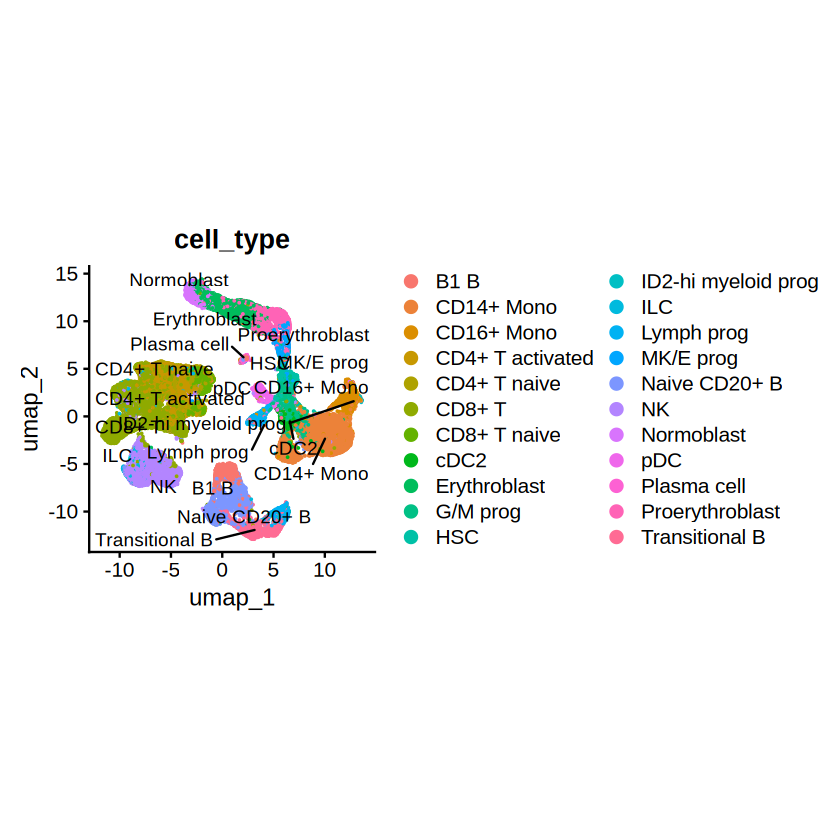

In [86]:
p = DimPlot(obj.seurat, 
        group.by = "cell_type",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)

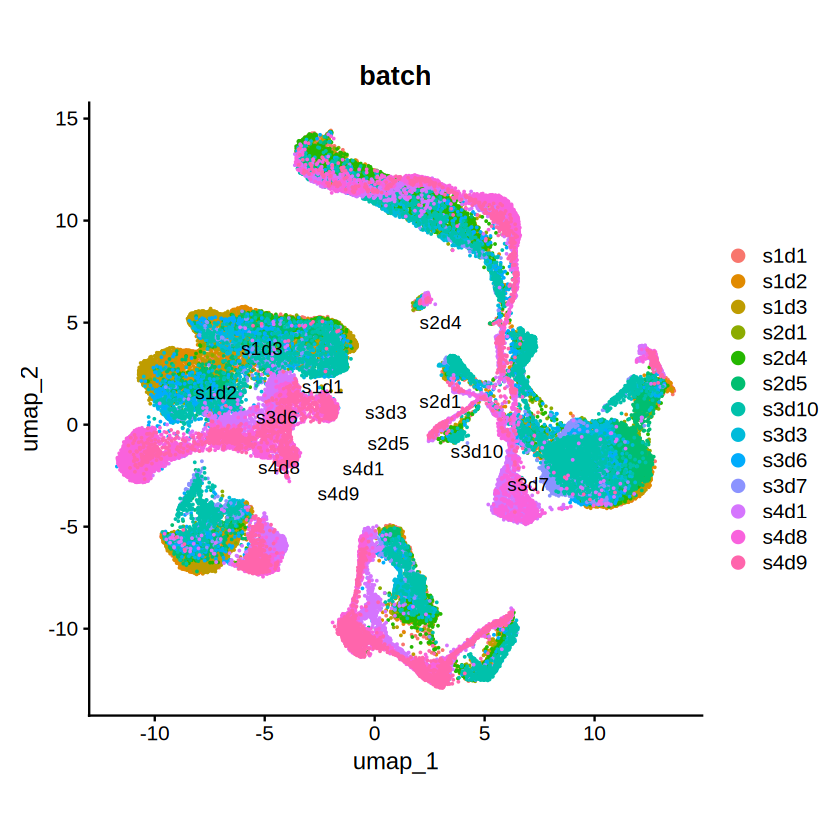

In [87]:
p = DimPlot(obj.seurat, 
        group.by = "batch",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.batch.pdf", 
       plot = p, 
       width = 10, height = 8)

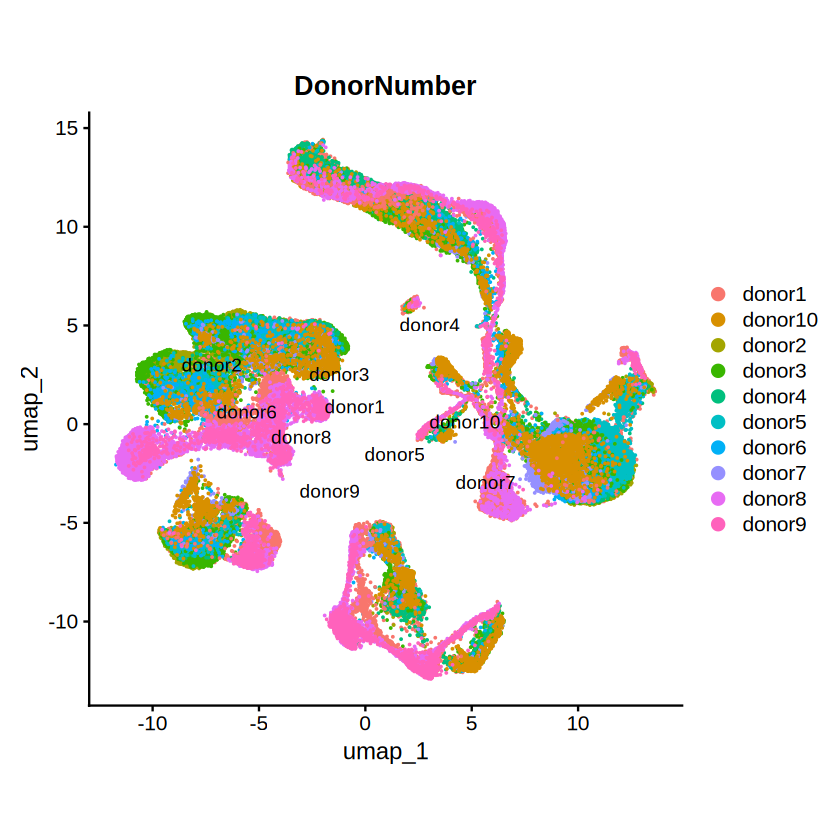

In [88]:
p = DimPlot(obj.seurat, 
        group.by = "DonorNumber",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.DonorNumber.pdf", 
       plot = p, 
       width = 10, height = 8)

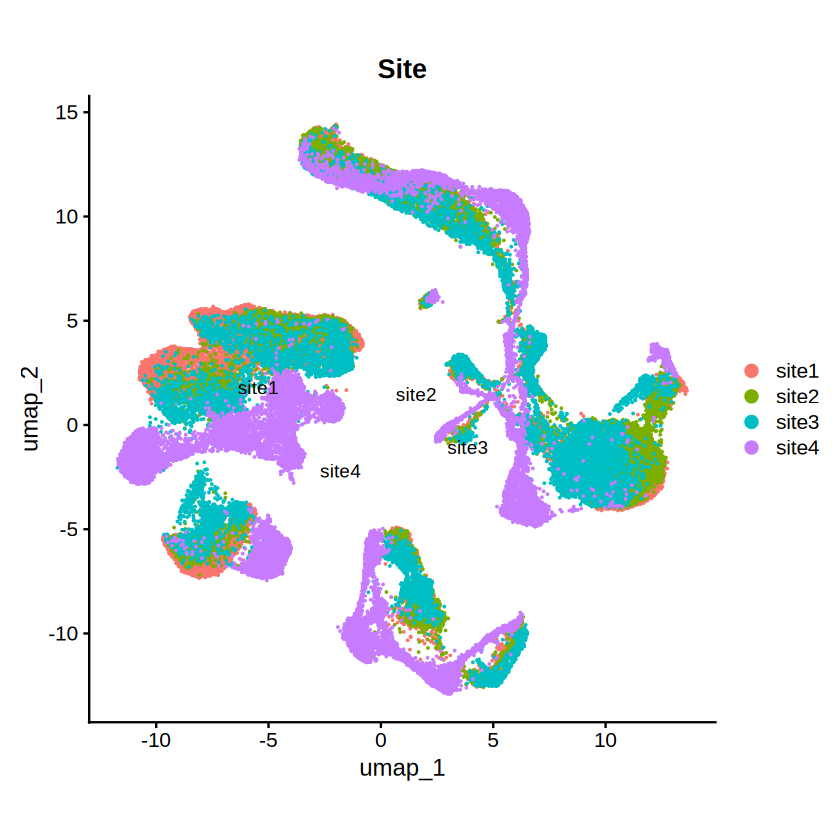

In [89]:
p = DimPlot(obj.seurat, 
        group.by = "Site",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.Site.pdf", 
       plot = p, 
       width = 10, height = 8)

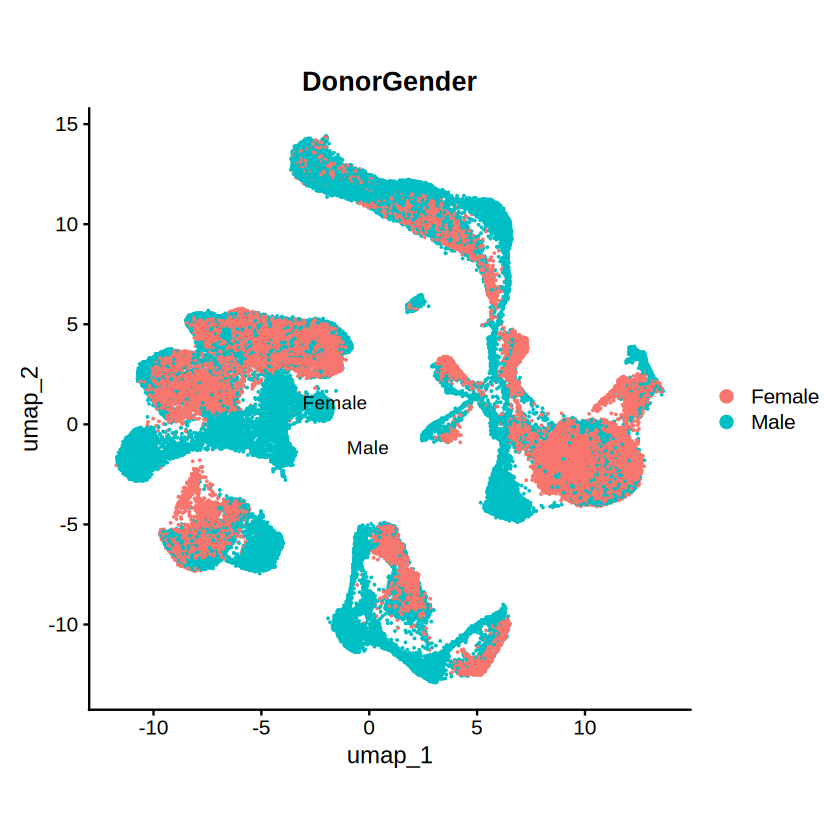

In [90]:
p = DimPlot(obj.seurat, 
        group.by = "DonorGender",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.DonorGender.pdf", 
       plot = p, 
       width = 10, height = 8)

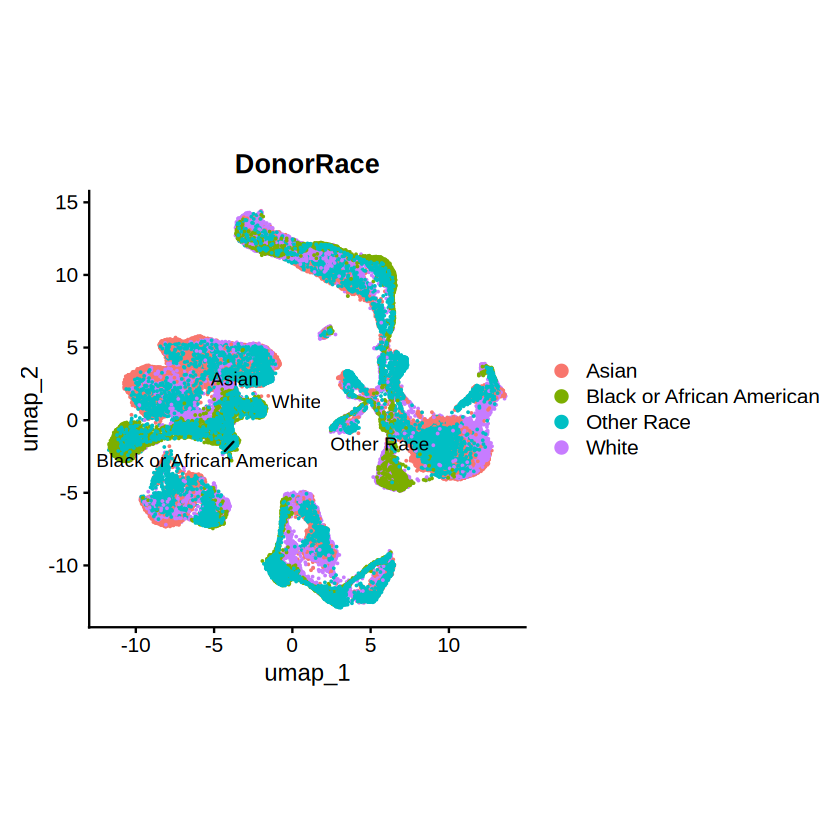

In [91]:
p = DimPlot(obj.seurat, 
        group.by = "DonorRace",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.DonorRace.pdf", 
       plot = p, 
       width = 10, height = 8)

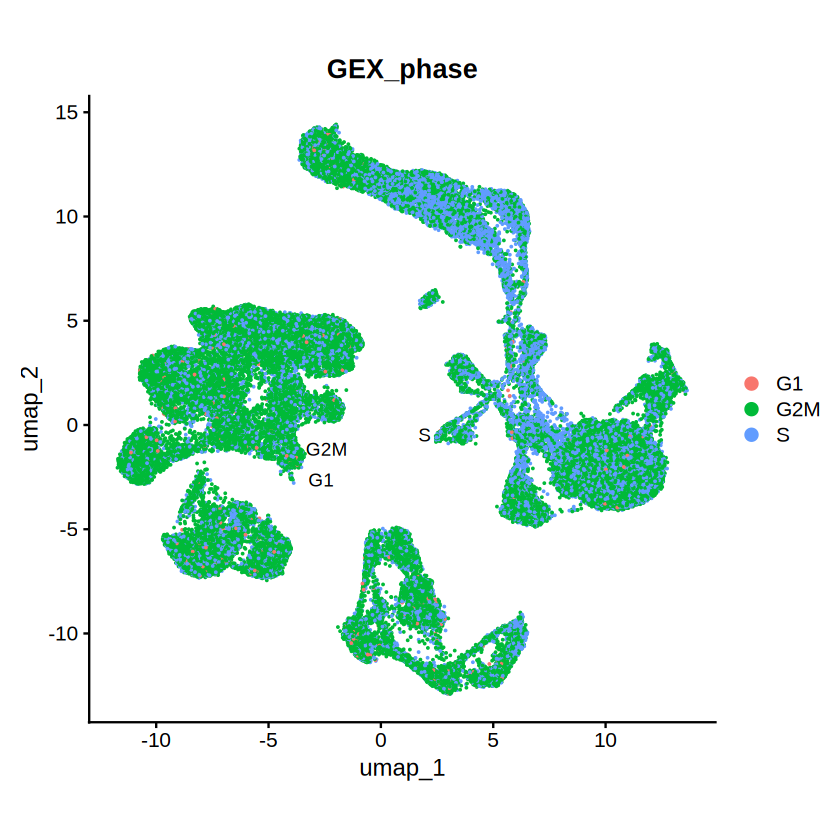

In [92]:
p = DimPlot(obj.seurat, 
        group.by = "GEX_phase",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.GEX_phase.pdf", 
       plot = p, 
       width = 10, height = 8)

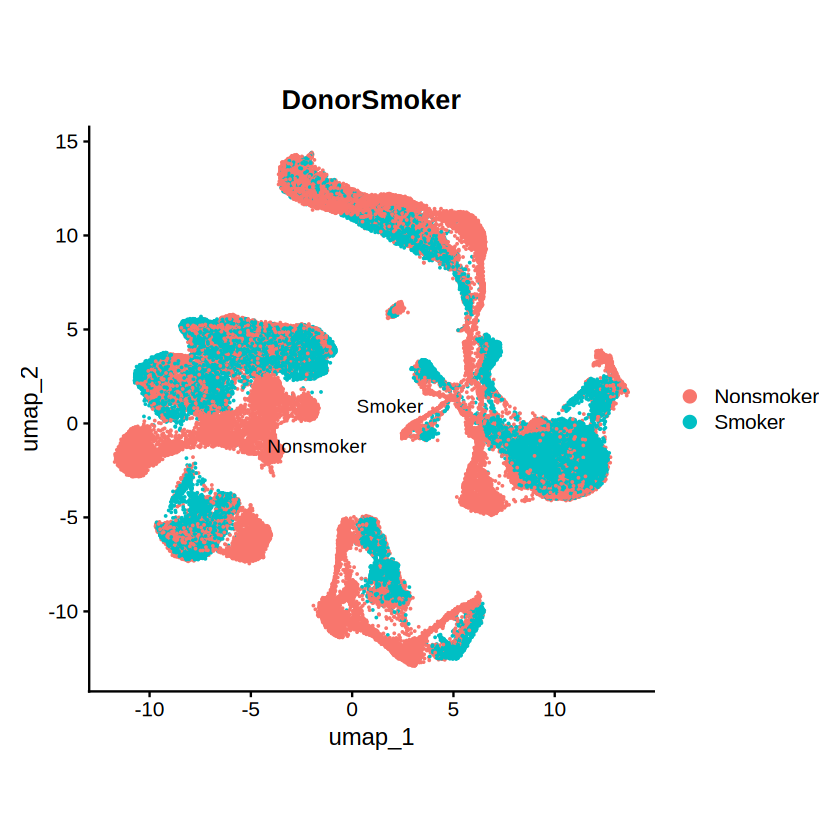

In [93]:
p = DimPlot(obj.seurat, 
        group.by = "DonorSmoker",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.DonorSmoker.pdf", 
       plot = p, 
       width = 10, height = 8)

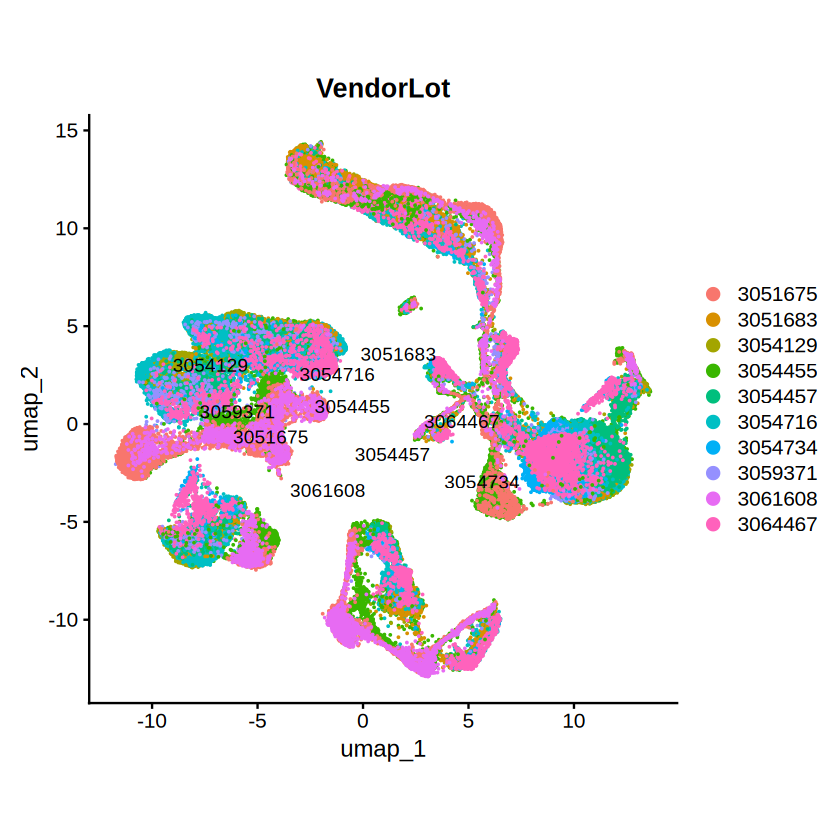

In [94]:
p = DimPlot(obj.seurat, 
        group.by = "VendorLot",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/UMAP.ATAC.VendorLot.pdf", 
       plot = p, 
       width = 10, height = 8)

Save data

In [95]:
saveRDS(obj.seurat,
        paste(dir.output, "obj.seurat.rds", sep = "/"))

In [96]:
saveRDS(obj.seurat@assays$RNA$counts,
        paste(dir.output, "matrix.rna.rds", sep = "/"))

In [97]:
saveRDS(obj.seurat@assays$ATAC$counts,
        paste(dir.output, "matrix.atac.rds", sep = "/"))

In [98]:
saveRDS(pairs.peak_gene,
        paste(dir.output, "pairs.rds", sep = "/"))

In [99]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.9 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.5.1        Matrix_1.6-5         GenomicRanges_1.54.1
 [4] GenomeInfoDb_1.38.1  IRanges_2.36.0       S4Vectors_0.40.2    

In [2]:
matrix.atac = readRDS("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/matrix.atac.rds")

In [ ]:
data.table::fwrite(as.data.frame(as.matrix(matrix.atac)),
                   "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/4.merge_peaks_from_22_cell_types.240523/matrix.atac.csv.gz",
                   row.names = T)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 278.8 GiB”
